In [73]:
import os
import json
import pandas as pd

In [74]:
%cd '/home/myilmaz/devel/551982_1475446_bundle_archive/'

/home/myilmaz/devel/551982_1475446_bundle_archive


In [75]:
kag=pd.read_csv('Kaggle/target_tables/8_risk_factors/Chronic kidney disease.csv')

In [76]:
kag.head()

,Unnamed: 0,Date,Study,Study Link,Journal,Severe,Severe lower bound,Severe upper bound,Severe p-value,Severe Significant,...,Fatality Significant,Fatality Adjusted,Fatality Calculated,Multivariate adjustment,Study Type,Sample Size,Study Population,Added on,Critical only,Discharged vs. death?
0,0,2020-06-01,Characteristics and Outcomes of COVID-19 Patie...,http://medrxiv.org/cgi/content/short/2020.05.2...,MedRxiv,NaN,NaN,NaN,NaN,NaN,...,Significant,Not Adjusted,Calculated,NaN,Retrospective observational study,13442,New York City Health and Hospital between Marc...,NaN,N,N
1,1,2020-05-31,Clinical Features and Short-term Outcomes of E...,https://www.sciencedirect.com/science/article/...,Int J Infect Dis,NaN,NaN,NaN,NaN,NaN,...,Significant,Not Adjusted,Extracted,NaN,Retrospective observational study,204,Renmin Hospital of Wuhan University from ...,NaN,N,N
2,2,2020-05-29,A clinical risk score to identify patients wit...,https://doi.org/10.1016/j.jinf.2020.05.064,J Infect,HR=0.90,0.54,1.51,0.7,Not Significant,...,Not Significant,Not Adjusted,Extracted,NaN,Retrospective observational study,1157,King’s College Hospital and Princess Royal Uni...,NaN,Y,N
3,3,2020-05-29,The Association Between Biomarkers and Clinica...,http://medrxiv.org/cgi/content/short/2020.05.2...,MedRxiv,NaN,NaN,NaN,NaN,NaN,...,Significant,Not Adjusted,Extracted,NaN,Retrospective observational study,299,299 patients with confirmed COVID-19 positive ...,NaN,Y,N
4,4,2020-05-29,Phenotypic characteristics and prognosis of in...,https://www.ncbi.nlm.nih.gov/pubmed/32472191/,Diabetologia,OR: 0.66,0.35,1.27,NaN,Not Significant,...,Not Significant,Not Adjusted,Extracted,NaN,Retrospective observational study,1317,The CORONADO study was launched in all French ...,NaN,Y,N


In [77]:
%ls document_parses

covid.ipynb  pdf_json/  pmc_json/


In [78]:
keep=['Epidemiology, clinical course, and outcomes of critically ill adults with COVID-19 in New York City: a prospective cohort study']
arts=set(kag['Study'])-set(keep)

In [79]:
creat=[]
for i in os.listdir('document_parses/pdf_json'):
    save=0
    savee=0

    with open('document_parses/pdf_json/'+i) as json_file:
        data = json.load(json_file)
        if data['metadata']['title'] not in list(arts):
        
            doc=[]
            for c,j in enumerate(data['body_text']):
            
                #texts.append(data['body_text'][c]['text'])
                row=[i,data['metadata']['title'],data['body_text'][c]['section'],data['body_text'][c]['text']]
                if data['body_text'][c]['text'].lower().find('creatinine')>-1:
                    save+=1
                if data['body_text'][c]['text'].lower().find('covid-19')>-1:
                    savee+=1
                if data['body_text'][c]['text'].lower().find('covid19')>-1:
                    savee+=1
                doc.append(row)
            if save>0:
                if savee>0:
                    creat.append(doc)
        else:
            pass

In [80]:
jsons=[j[0] for i in creat for j in i]
titles=[j[1] for i in creat for j in i]
sections=[j[2] for i in creat for j in i]
text=[j[1]+'.  '+j[2]+'.  '+j[3] for i in creat for j in i]

In [81]:
creats=pd.DataFrame(None,columns=['jsons','titles','sections','text'])

In [82]:
creats.jsons=jsons
creats.titles=titles
creats.sections=sections
creats.text=text

In [83]:
creats.head()

,jsons,titles,sections,text
0,fd4ccbdac4837e90209823ff38dbb82e58c51c3f.json,Journal Pre-proof Breastfeeding and Medication...,Introduction,Journal Pre-proof Breastfeeding and Medication...
1,fd4ccbdac4837e90209823ff38dbb82e58c51c3f.json,Journal Pre-proof Breastfeeding and Medication...,Introduction,Journal Pre-proof Breastfeeding and Medication...
2,fd4ccbdac4837e90209823ff38dbb82e58c51c3f.json,Journal Pre-proof Breastfeeding and Medication...,Introduction,Journal Pre-proof Breastfeeding and Medication...
3,fd4ccbdac4837e90209823ff38dbb82e58c51c3f.json,Journal Pre-proof Breastfeeding and Medication...,Mammary glands,Journal Pre-proof Breastfeeding and Medication...
4,fd4ccbdac4837e90209823ff38dbb82e58c51c3f.json,Journal Pre-proof Breastfeeding and Medication...,Mammary glands,Journal Pre-proof Breastfeeding and Medication...


In [84]:
docs=creats.copy(deep=True)

In [85]:
docs.drop_duplicates(keep='first',inplace=True)

In [86]:
docs.head()

,jsons,titles,sections,text
0,fd4ccbdac4837e90209823ff38dbb82e58c51c3f.json,Journal Pre-proof Breastfeeding and Medication...,Introduction,Journal Pre-proof Breastfeeding and Medication...
1,fd4ccbdac4837e90209823ff38dbb82e58c51c3f.json,Journal Pre-proof Breastfeeding and Medication...,Introduction,Journal Pre-proof Breastfeeding and Medication...
2,fd4ccbdac4837e90209823ff38dbb82e58c51c3f.json,Journal Pre-proof Breastfeeding and Medication...,Introduction,Journal Pre-proof Breastfeeding and Medication...
3,fd4ccbdac4837e90209823ff38dbb82e58c51c3f.json,Journal Pre-proof Breastfeeding and Medication...,Mammary glands,Journal Pre-proof Breastfeeding and Medication...
4,fd4ccbdac4837e90209823ff38dbb82e58c51c3f.json,Journal Pre-proof Breastfeeding and Medication...,Mammary glands,Journal Pre-proof Breastfeeding and Medication...


In [87]:
docs.to_csv('covid.csv')

In [88]:
docs=pd.read_csv('covid.csv')

In [89]:
import os


import pyspark.sql.functions as F
from pyspark.sql.functions import monotonically_increasing_id
import json
import os
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession


from sparknlp.annotator import *

from sparknlp.base import *

# Install pyspark
! pip install --ignore-installed -q pyspark==2.4.4


# Install Spark NLP
! pip install --ignore-installed -q spark-nlp==2.5


import sparknlp

print (sparknlp.version())

import json
import os
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
from sparknlp.annotator import *

from sparknlp.base import *

from pyspark.sql.functions import monotonically_increasing_id
import pyspark.sql.functions as F
import pyspark.sql.types as t




You should consider upgrading via the '/home/myilmaz/devel/mag/notebooks/3.7env/bin/python -m pip install --upgrade pip' command.
ERROR: spark-nlp-jsl 2.5.4rc4 has requirement spark-nlp==2.5.4, but you'll have spark-nlp 2.5.0 which is incompatible.
You should consider upgrading via the '/home/myilmaz/devel/mag/notebooks/3.7env/bin/python -m pip install --upgrade pip' command.
2.5.0


In [90]:

spark=sparknlp.start()

In [91]:
docs.fillna('',inplace=True)

In [92]:
docs.head(1)

,Unnamed: 0,jsons,titles,sections,text
0,0,fd4ccbdac4837e90209823ff38dbb82e58c51c3f.json,Journal Pre-proof Breastfeeding and Medication...,Introduction,Journal Pre-proof Breastfeeding and Medication...


In [93]:
sparkdocs=spark.createDataFrame(docs).toDF('docid','json','title','section','text')

In [94]:
document_assembler = DocumentAssembler() \
        .setInputCol("text")\
        .setOutputCol('document')
    
sentence_detector = SentenceDetector() \
        .setInputCols(["document"]) \
        .setOutputCol("sentence")

tokenizer = Tokenizer() \
        .setInputCols(["sentence"]) \
        .setOutputCol("token")

word_embeddings = WordEmbeddingsModel.load("/home/myilmaz/cache_pretrained/embeddings_clinical_en_2.4.0_2.4_1580237286004")\
  .setInputCols(["sentence", "token"])\
  .setOutputCol("embeddings")
clinical_ner = NerDLModel.load('/home/myilmaz/cache_pretrained/ner_clinical_en_2.4.0_2.4_1580237286004') \
        .setInputCols(["sentence", "token", "embeddings"]) \
        .setOutputCol("ner")
ner_converter = NerConverter() \
  .setInputCols(["sentence", "token", "ner"]) \
  .setOutputCol("ner_chunk")
nlpPipeline = Pipeline(stages=[document_assembler,sentence_detector,tokenizer,
    word_embeddings,
    clinical_ner,ner_converter
    ])


empty_data = spark.createDataFrame([[""]]).toDF("text")

model = nlpPipeline.fit(empty_data)


In [95]:
results=model.transform(sparkdocs)

In [96]:
results.columns

['docid',
 'json',
 'title',
 'section',
 'text',
 'document',
 'sentence',
 'token',
 'embeddings',
 'ner',
 'ner_chunk']

In [97]:
exploded = results.select('docid','section',F.explode(F.arrays_zip('token.metadata','token.result','ner.result')).alias("cols")) \
        .select('docid','section',F.expr("cols['0'].sentence").alias("sentid"),
        F.col('cols.1').alias("token"),F.col('cols.2').alias("label"))

In [99]:
exploded.write.option("header", "true").csv("covid2.csv")

In [100]:
os.listdir('covid2.csv')[0]

'.part-00002-cdd9888b-ccd7-4cb1-b68d-d7414ade4f70-c000.csv.crc'

In [101]:
import pyspark.sql.types as t
myschema = t.StructType(
   [
    t.StructField('docid', t.IntegerType(), True),
    t.StructField('section', t.StringType(), True),
    t.StructField('sentid', t.IntegerType(), True),
    t.StructField('token', t.StringType(), True),
    t.StructField('label', t.StringType(), True)

   ]
  )

In [102]:
csvs=os.listdir('covid2.csv')[0:13]
big=pd.DataFrame(None)
for i in csvs:
    
    dfs=spark.read.csv('covid2.csv/'+i,sep=',',schema=myschema,header=True)
    one=dfs.toPandas()
    big=big.append(one)

In [103]:
import numpy as np

tokens=[]
savei=''
save=0
for i,j in zip(big.token,big.label):
    if j.split('-')[0]!='I':
        if save<0:
            tokens[save]=savei
            tokens.append(np.nan)
            savei=i
            save=0
            continue
        else:
            tokens.append(savei)
            savei=i
            save=0
            continue
    elif j.split('-')[0]=='I':
        savei+=' '+i
        save-=1
        tokens.append(np.nan)
    else:
        tokens.append(np.nan)

               
if save<0:
    tokens[save]=savei
    tokens.append(np.nan)
else:
    tokens.append(savei) 
    
tokens=tokens[1:]
        

In [104]:
big['chunks']=tokens

In [105]:
bigdf=big[big['chunks'].notnull()]

In [106]:
bigdf=bigdf[bigdf['label']!='O']

In [107]:
bigdf['chunks'].value_counts()

SARS-CoV-2                            3409
treatment                             1530
AKI                                   1510
SARS-CoV-2 infection                  1505
this study                            1296
                                      ... 
the virus to other organs                1
SARS-CoV-2 meningitis/encephalitis       1
Plasma exchange                          1
Interleukins ( IL-2 receptor             1
the MTT assay                            1
Name: chunks, Length: 133561, dtype: int64

In [108]:
problems=bigdf[bigdf['label']=='B-PROBLEM']

In [109]:
creat=problems[problems['chunks'].str.contains('creatinine')]
len(problems[problems['chunks'].str.contains('creatinine')])

291

In [110]:
hyper=problems[problems['chunks'].str.contains('hypertension')]
len(problems[problems['chunks'].str.contains('hypertension')])

1473

In [111]:
inflam=problems[problems['chunks'].str.contains('inflammatory')]
len(problems[problems['chunks'].str.contains('inflammatory')])

1893

In [112]:
cyto=problems[problems['chunks'].str.contains('cytokine')]
len(problems[problems['chunks'].str.contains('cytokine')])

1560

In [113]:
tests=bigdf[bigdf['label']=='B-TEST']

In [114]:
creat2=tests[tests['chunks'].str.contains('creatinine')]
len(tests[tests['chunks'].str.contains('creatinine')])

1392

In [115]:
hyper2=pd.DataFrame(creat2.merge(hyper,on=['docid','section'],how='inner'))
len(hyper2.drop_duplicates(keep='first'))

214

In [124]:
hyper2=pd.DataFrame(creat2.merge(hyper,on=['docid'],how='inner'))
len(hyper2.drop_duplicates(keep='first'))

214

In [120]:
hyper2=pd.DataFrame(creat2.merge(inflam,on=['docid','section'],how='inner'))
len(hyper2.drop_duplicates(keep='first'))

100

In [122]:
hyper2=pd.DataFrame(creat2.merge(cyto,on=['docid','section'],how='inner'))
len(hyper2.drop_duplicates(keep='first'))

94

In [125]:
probhist=pd.DataFrame(problems['chunks'].value_counts())
probhist=probhist.rename(columns={'chunks':'counts'})
probhist2=probhist.iloc[0:100]

In [126]:
testhist=pd.DataFrame(tests['chunks'].value_counts())
testhist=testhist.rename(columns={'chunks':'counts'})
testhist2=testhist.iloc[0:100]

In [127]:
testhist2.head(40)

,counts
this study,1295
the study,1262
CRP,805
our study,668
creatinine,632
studies,611
data,610
CI,577
Accepted Article,564
A,536


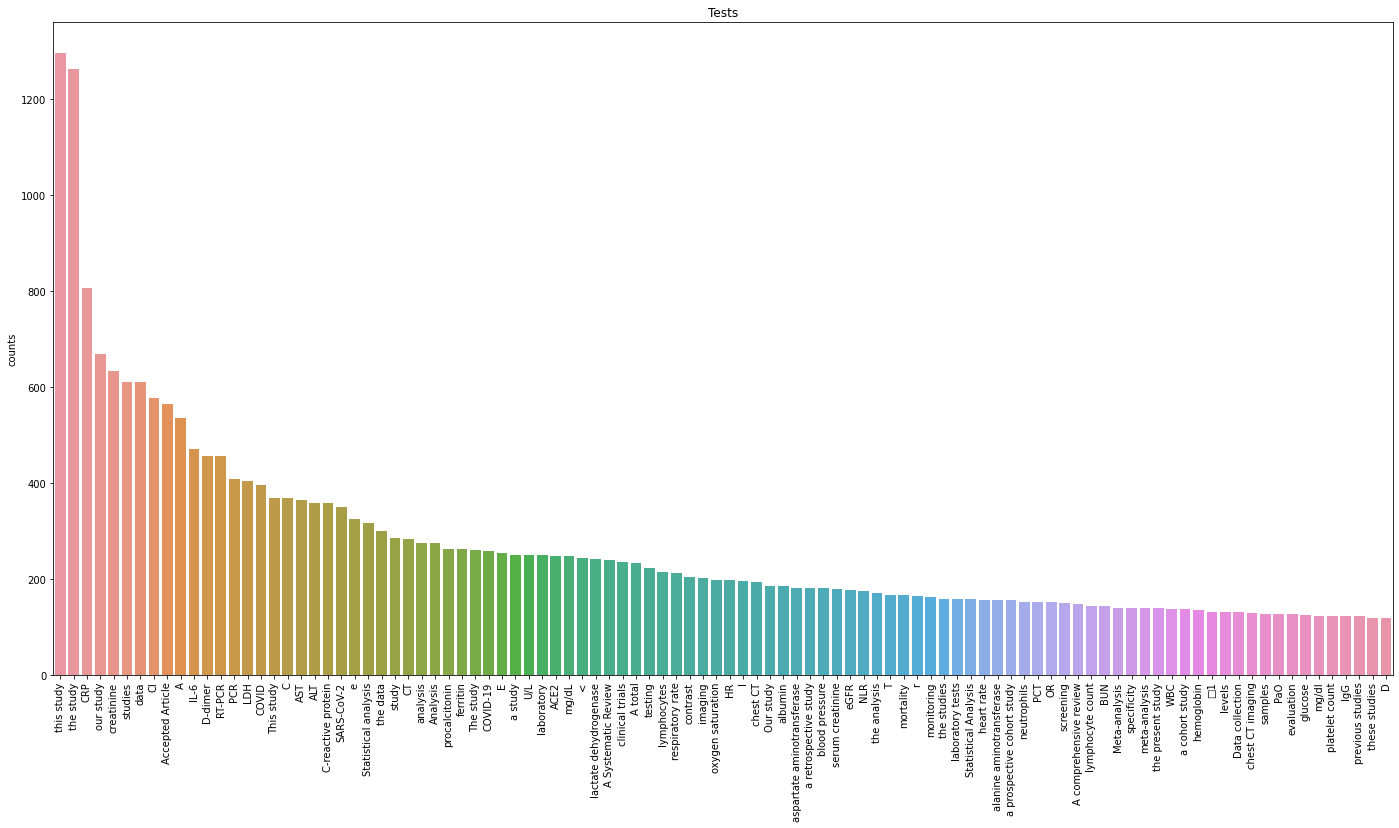

In [128]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(figsize =(24,12))
chart=sns.barplot(testhist2.index,testhist2['counts'])
chart.set_xticklabels(testhist2.index,rotation=90)
plt.title('Tests')
plt.show()

In [129]:
probhist2.head(40)

,counts
SARS-CoV-2,2533
AKI,1508
SARS-CoV-2 infection,1505
death,1194
fever,1120
hypertension,1087
diabetes,1002
ARDS,949
SARS,926
the disease,914


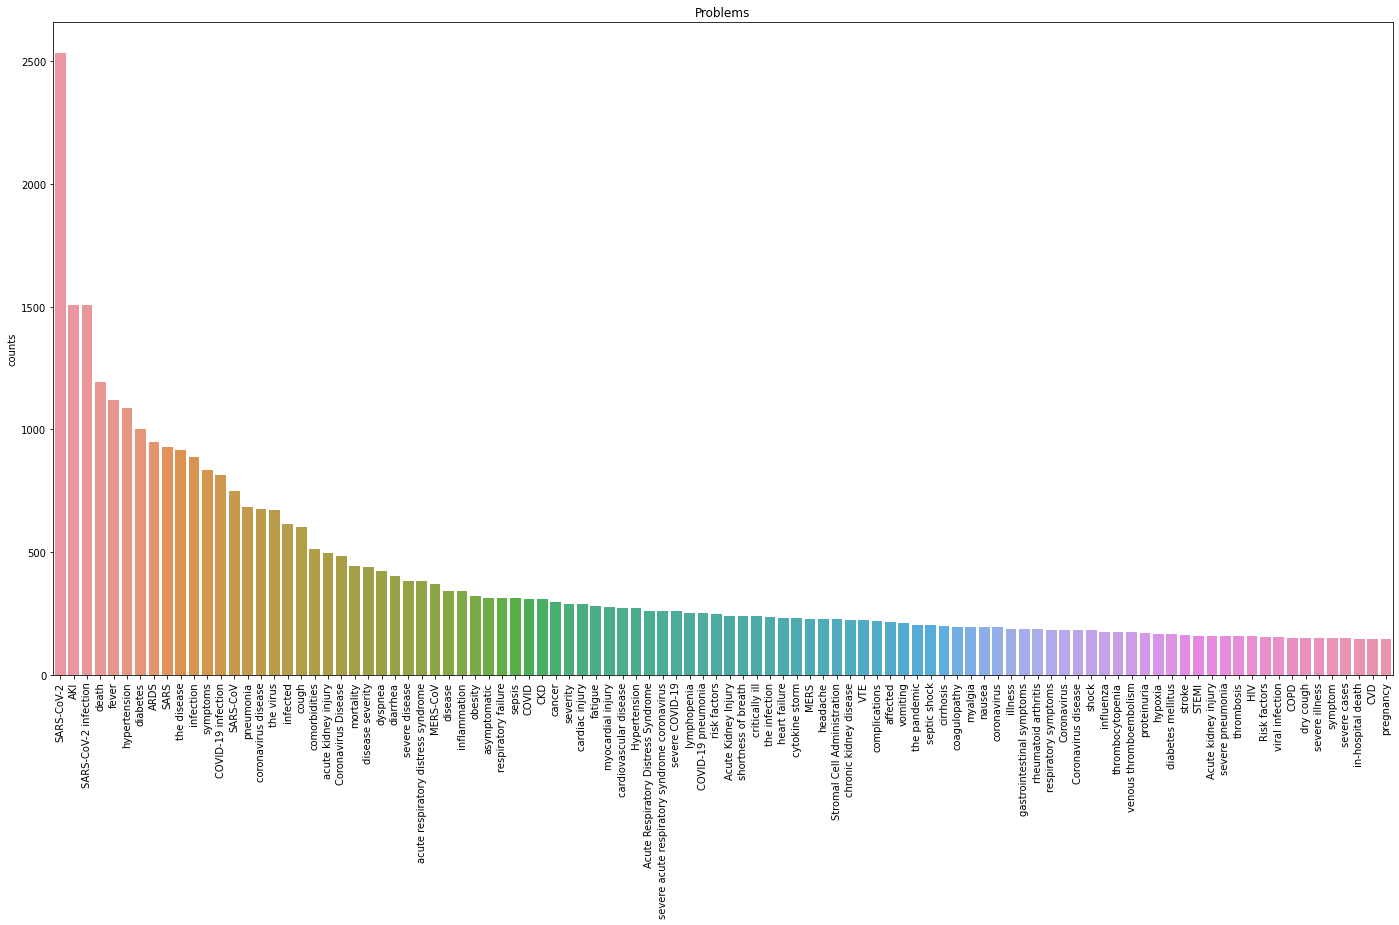

In [130]:
import seaborn as sns
import seaborn as sns
fig, ax = plt.subplots(figsize =(24,12))
chart=sns.barplot(probhist2.index,probhist2['counts'])
chart.set_xticklabels(probhist2.index,rotation=90)
plt.title('Problems')
plt.show()